In [3]:
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
import PIL.Image
from PIL import ImageOps
import cv2

from IPython.display import display, Image
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from math import radians
import random

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses, callbacks
import numpy as np

import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

import pyglet
pyglet.options['shadow_window'] = False
import os
import numpy as np
import trimesh

from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     Viewer, OffscreenRenderer, RenderFlags

C:\Users\91866\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# CREATE CNN MODEL

In [4]:
class CNNPosRotEstimator():
    def __init__(self, num_convs=2, activation='relu', filters=32, kernel_size=3, strides=3, padding='same', out_size=6):
        self.num_convs = num_convs
        self.activation = activation
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.out_size = out_size

    
    def create_model(self):
        model = models.Sequential()

        for _ in range(self.num_convs):
            model.add(layers.Conv2D(filters=self.filters, kernel_size=self.kernel_size, strides=self.strides, 
                                padding=self.padding, activation=self.activation, use_bias=True))
            model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation=self.activation))
        model.add(layers.Dense(self.out_size))

        return model

In [5]:
def extract_poses(file_path):
    camera_data_list = []
    angle_list = []

    with open(file_path, 'r') as file:
        current_camera_data = []

        for line in file:
            if 'Camera position' in line:
                position_values = [float(val) for val in line.split(':')[2].strip()[1:-1].split(',')]
                current_camera_data.extend(position_values)
            elif 'Angle' in line:
                angle_list.append(float(line.split(':')[2].strip()))
            elif 'Camera rotation' in line:
                rotation_values = [float(val) for val in line.split(':')[2].strip()[1:-1].split(',')]
                current_camera_data.extend(rotation_values)

                camera_data_list.append(current_camera_data)
                current_camera_data = []
            else:
                pass

    return angle_list, camera_data_list

In [6]:
data_dir = "dataset_256x256_qrcode_A_yaw_pose"

images_list = []

for fname in os.listdir(data_dir):
    if fname != 'poses.txt':
        img = imageio.imread(os.path.join(data_dir, fname))
        img_arr = np.array(img)
        images_list.append(img_arr[:,:,:3]/255.0)
    else:
        angles_list, poses_list = extract_poses(os.path.join(data_dir, fname))


images_array = np.array(images_list)
angles_array = np.array(angles_list)
poses_array = np.array(poses_list)


print(f"Images Array Shape = {images_array.shape}")
print(f"Angles Array Shape = {angles_array.shape}")
print(f"Poses Array Shape = {poses_array.shape}")

Images Array Shape = (691, 256, 256, 3)
Angles Array Shape = (691,)
Poses Array Shape = (691, 6)


In [7]:
# random shuffling
import random

indices = list(range(images_array.shape[0]))
random.shuffle(indices)

new_images_list = []
new_angle_list = []
for i in indices:
    new_images_list.append(images_array[i,:])
    new_angle_list.append(angles_array[i])

new_images_array = np.array(new_images_list)
new_angles_array = np.array(new_angle_list)

train_fraction = 0.7
num_train = int(train_fraction * images_array.shape[0])

print(f"Training on {num_train} images")

training_data, training_target = np.mean(new_images_array[:num_train,:,:,:], axis=3), new_angles_array[:num_train]
validation_data, validation_target = np.mean(new_images_array[num_train:,:,:,:], axis=3), new_angles_array[num_train:]

training_data = training_data.reshape((training_data.shape[0], training_data.shape[1], training_data.shape[2], 1))
validation_data = validation_data.reshape((validation_data.shape[0], validation_data.shape[1], validation_data.shape[2], 1))

Training on 483 images


In [8]:
# Model Architecture
num_convs = 2
activation= 'relu'
filters = 32
kernel_size = 3
strides = 3
padding = 'same'
out_size = 1

In [9]:
# Hyperparameters
EPOCHS = 75
BATCH_SIZE = 32
LEARNING_RATE = 0.03

loss_fn = losses.MeanSquaredError()
#callback = callbacks.EarlyStopping(monitor='val_loss')
callback = callbacks.ModelCheckpoint(filepath="angle_predictor", monitor='val_loss', save_best_only=True, mode='min')

In [10]:

CNN_model = CNNPosRotEstimator(num_convs=num_convs, activation=activation, 
                               filters=filters, kernel_size=kernel_size, strides=strides, 
                               padding=padding, out_size=out_size).create_model()

CNN_model.build(input_shape = (None, training_data.shape[1], training_data.shape[2], 1))
CNN_model.summary()

CNN_model.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=loss_fn)

# If you want to use early stopping
history = CNN_model.fit(training_data, training_target, epochs=EPOCHS, validation_data=(validation_data, validation_target), verbose=1, callbacks=callback)

# # If you DON'T want to use early stopping
# history = CNN_model.fit(training_data, training_target, epochs=EPOCHS, validation_data=(validation_data, validation_target), verbose=1)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 86, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 43, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 64)               

INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 4s 159ms/step - loss: 17064.8848 - val_loss: 11723.6113
Epoch 2/75
15/16 [===========================>..] - ETA: 0s - loss: 9084.0820INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 113ms/step - loss: 9041.0957 - val_loss: 10069.6211
Epoch 3/75
15/16 [===========================>..] - ETA: 0s - loss: 8570.3086INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 117ms/step - loss: 8544.7373 - val_loss: 8595.1729
Epoch 4/75
16/16 [==============================] - 1s 43ms/step - loss: 7797.3540 - val_loss: 9560.2305
Epoch 5/75
16/16 [==============================] - 1s 44ms/step - loss: 8776.0361 - val_loss: 9376.3145
Epoch 6/75
15/16 [===========================>..] - ETA: 0s - loss: 8345.3936INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 111ms/step - loss: 8325.9062 - val_loss: 6285.1353
Epoch 7/75
15/16 [===========================>..] - ETA: 0s - loss: 5984.5317INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 115ms/step - loss: 5955.5293 - val_loss: 5579.2856
Epoch 8/75
15/16 [===========================>..] - ETA: 0s - loss: 5531.4639INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 131ms/step - loss: 5520.3076 - val_loss: 4656.3901
Epoch 9/75
16/16 [==============================] - 1s 45ms/step - loss: 4513.8374 - val_loss: 12117.6084
Epoch 10/75
16/16 [==============================] - 1s 43ms/step - loss: 6612.5747 - val_loss: 5328.6543
Epoch 11/75
15/16 [===========================>..] - ETA: 0s - loss: 4964.7236INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 112ms/step - loss: 4948.6719 - val_loss: 3085.9810
Epoch 12/75
15/16 [===========================>..] - ETA: 0s - loss: 3755.6680INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 116ms/step - loss: 3762.5354 - val_loss: 2650.4180
Epoch 13/75
15/16 [===========================>..] - ETA: 0s - loss: 3243.6133INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 111ms/step - loss: 3229.2375 - val_loss: 2067.6531
Epoch 14/75
15/16 [===========================>..] - ETA: 0s - loss: 3429.9619INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 119ms/step - loss: 3417.8477 - val_loss: 1718.1823
Epoch 15/75
16/16 [==============================] - 1s 43ms/step - loss: 2175.8472 - val_loss: 1831.3169
Epoch 16/75
14/16 [=========================>....] - ETA: 0s - loss: 1905.4987INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 120ms/step - loss: 1966.5950 - val_loss: 1480.8179
Epoch 17/75
15/16 [===========================>..] - ETA: 0s - loss: 1539.4833INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 113ms/step - loss: 1543.3840 - val_loss: 1084.8101
Epoch 18/75
16/16 [==============================] - 1s 42ms/step - loss: 1391.8246 - val_loss: 2456.2778
Epoch 19/75
15/16 [===========================>..] - ETA: 0s - loss: 1255.1477INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 112ms/step - loss: 1251.6188 - val_loss: 690.4238
Epoch 20/75
14/16 [=========================>....] - ETA: 0s - loss: 832.3951INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 116ms/step - loss: 882.7877 - val_loss: 455.3104
Epoch 21/75
16/16 [==============================] - 1s 43ms/step - loss: 690.1106 - val_loss: 469.3130
Epoch 22/75
15/16 [===========================>..] - ETA: 0s - loss: 464.4860INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 111ms/step - loss: 462.1285 - val_loss: 215.7046
Epoch 23/75
16/16 [==============================] - 1s 44ms/step - loss: 280.7679 - val_loss: 223.2745
Epoch 24/75
15/16 [===========================>..] - ETA: 0s - loss: 227.8716INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 112ms/step - loss: 227.9504 - val_loss: 124.5140
Epoch 25/75
16/16 [==============================] - 1s 42ms/step - loss: 269.5631 - val_loss: 219.6497
Epoch 26/75
16/16 [==============================] - 1s 43ms/step - loss: 228.0886 - val_loss: 404.6477
Epoch 27/75
16/16 [==============================] - 1s 44ms/step - loss: 224.7371 - val_loss: 213.0727
Epoch 28/75
16/16 [==============================] - 1s 42ms/step - loss: 221.8385 - val_loss: 156.6793
Epoch 29/75
15/16 [===========================>..] - ETA: 0s - loss: 136.8945INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 143ms/step - loss: 136.1687 - val_loss: 120.2674
Epoch 30/75
16/16 [==============================] - 1s 42ms/step - loss: 119.8028 - val_loss: 445.9222
Epoch 31/75
16/16 [==============================] - 1s 45ms/step - loss: 209.2511 - val_loss: 313.9463
Epoch 32/75
15/16 [===========================>..] - ETA: 0s - loss: 158.1536INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 114ms/step - loss: 157.8712 - val_loss: 105.6602
Epoch 33/75
15/16 [===========================>..] - ETA: 0s - loss: 90.6789INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 112ms/step - loss: 90.6168 - val_loss: 103.5437
Epoch 34/75
16/16 [==============================] - 1s 42ms/step - loss: 101.5963 - val_loss: 105.1142
Epoch 35/75
15/16 [===========================>..] - ETA: 0s - loss: 98.7825 INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 113ms/step - loss: 98.3463 - val_loss: 58.5032
Epoch 36/75
16/16 [==============================] - 1s 43ms/step - loss: 60.5170 - val_loss: 282.9518
Epoch 37/75
16/16 [==============================] - 1s 43ms/step - loss: 157.4144 - val_loss: 272.3556
Epoch 38/75
15/16 [===========================>..] - ETA: 0s - loss: 148.9825INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 113ms/step - loss: 148.6749 - val_loss: 50.4122
Epoch 39/75
16/16 [==============================] - 1s 43ms/step - loss: 69.2177 - val_loss: 67.7864
Epoch 40/75
15/16 [===========================>..] - ETA: 0s - loss: 44.1975INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 112ms/step - loss: 44.0468 - val_loss: 32.3606
Epoch 41/75
16/16 [==============================] - 1s 42ms/step - loss: 40.5780 - val_loss: 71.5123
Epoch 42/75
16/16 [==============================] - 1s 46ms/step - loss: 42.4269 - val_loss: 36.0091
Epoch 43/75
15/16 [===========================>..] - ETA: 0s - loss: 33.9349INFO:tensorflow:Assets written to: angle_predictor\assets


INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 115ms/step - loss: 33.7838 - val_loss: 26.6718
Epoch 44/75
16/16 [==============================] - 1s 42ms/step - loss: 57.3836 - val_loss: 255.2996
Epoch 45/75
16/16 [==============================] - 1s 42ms/step - loss: 61.4996 - val_loss: 82.4497
Epoch 46/75
16/16 [==============================] - 1s 43ms/step - loss: 63.7482 - val_loss: 57.6546
Epoch 47/75
16/16 [==============================] - 1s 44ms/step - loss: 53.1021 - val_loss: 52.0954
Epoch 48/75
16/16 [==============================] - 1s 41ms/step - loss: 36.9233 - val_loss: 43.6568
Epoch 49/75
16/16 [==============================] - 1s 43ms/step - loss: 90.6336 - val_loss: 489.7250
Epoch 50/75
16/16 [==============================] - 1s 42ms/step - loss: 251.5490 - val_loss: 145.9964
Epoch 51/75
16/16 [==============================] - 1s 42ms/step - loss: 221.2323 - val_loss: 267.5446
Epoch 52/75
16/16 [==============================] - 1s 44ms/step - loss: 101.9072 - va

INFO:tensorflow:Assets written to: angle_predictor\assets


16/16 [==============================] - 2s 116ms/step - loss: 22.0538 - val_loss: 18.9155


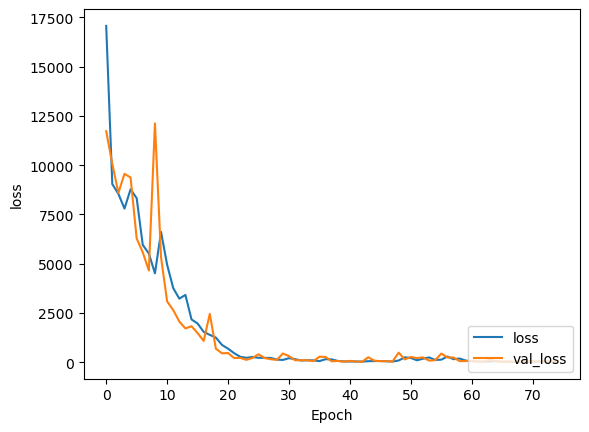

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')
plt.show()

In [12]:
pred_list = []
ground_list = []


grayscale_image = np.mean(images_array[3], axis=2)
print(grayscale_image.shape)
for i in range(len(images_array)):
    image = images_array[i]
    pose = angles_array[i]
    
    grayscale_image = np.mean(image, axis=2).reshape((256, 256, 1))

    # Predict the pose
    predicted_pose = CNN_model.predict(grayscale_image.reshape(1,256,256,1))

    print(i)
    pred = predicted_pose
    pred_f = float(pred[0, 0])*360
    pred_list.append(pred_f)
    
    ground = pose
    ground_f = float(ground)*360
    ground_list.append(ground_f)
    

(256, 256)
1/1 [==============================] - 0s 163ms/step
0
1/1 [==============================] - 0s 38ms/step
1
1/1 [==============================] - 0s 31ms/step
2
1/1 [==============================] - 0s 33ms/step
3
1/1 [==============================] - 0s 41ms/step
4
1/1 [==============================] - 0s 36ms/step
5
1/1 [==============================] - 0s 27ms/step
6
1/1 [==============================] - 0s 31ms/step
7
1/1 [==============================] - 0s 38ms/step
8
1/1 [==============================] - 0s 41ms/step
9
1/1 [==============================] - 0s 38ms/step
10
1/1 [==============================] - 0s 51ms/step
11
1/1 [==============================] - 0s 45ms/step
12
1/1 [==============================] - 0s 34ms/step
13
1/1 [==============================] - 0s 29ms/step
14
1/1 [==============================] - 0s 40ms/step
15
1/1 [==============================] - 0s 31ms/step
16
1/1 [==============================] - 0s 28ms/step
17
1/1 [===

1/1 [==============================] - 0s 52ms/step
148
1/1 [==============================] - 0s 37ms/step
149
1/1 [==============================] - 0s 42ms/step
150
1/1 [==============================] - 0s 35ms/step
151
1/1 [==============================] - 0s 44ms/step
152
1/1 [==============================] - 0s 31ms/step
153
1/1 [==============================] - 0s 36ms/step
154
1/1 [==============================] - 0s 34ms/step
155
1/1 [==============================] - 0s 41ms/step
156
1/1 [==============================] - 0s 39ms/step
157
1/1 [==============================] - 0s 36ms/step
158
1/1 [==============================] - 0s 32ms/step
159
1/1 [==============================] - 0s 49ms/step
160
1/1 [==============================] - 0s 37ms/step
161
1/1 [==============================] - 0s 38ms/step
162
1/1 [==============================] - 0s 49ms/step
163
1/1 [==============================] - 0s 46ms/step
164
1/1 [==============================] - 0s 45ms/s

1/1 [==============================] - 0s 31ms/step
294
1/1 [==============================] - 0s 34ms/step
295
1/1 [==============================] - 0s 40ms/step
296
1/1 [==============================] - 0s 29ms/step
297
1/1 [==============================] - 0s 30ms/step
298
1/1 [==============================] - 0s 36ms/step
299
1/1 [==============================] - 0s 31ms/step
300
1/1 [==============================] - 0s 38ms/step
301
1/1 [==============================] - 0s 34ms/step
302
1/1 [==============================] - 0s 39ms/step
303
1/1 [==============================] - 0s 27ms/step
304
1/1 [==============================] - 0s 31ms/step
305
1/1 [==============================] - 0s 28ms/step
306
1/1 [==============================] - 0s 28ms/step
307
1/1 [==============================] - 0s 32ms/step
308
1/1 [==============================] - 0s 28ms/step
309
1/1 [==============================] - 0s 50ms/step
310
1/1 [==============================] - 0s 35ms/s

1/1 [==============================] - 0s 29ms/step
440
1/1 [==============================] - 0s 30ms/step
441
1/1 [==============================] - 0s 29ms/step
442
1/1 [==============================] - 0s 41ms/step
443
1/1 [==============================] - 0s 31ms/step
444
1/1 [==============================] - 0s 30ms/step
445
1/1 [==============================] - 0s 39ms/step
446
1/1 [==============================] - 0s 36ms/step
447
1/1 [==============================] - 0s 32ms/step
448
1/1 [==============================] - 0s 37ms/step
449
1/1 [==============================] - 0s 32ms/step
450
1/1 [==============================] - 0s 29ms/step
451
1/1 [==============================] - 0s 33ms/step
452
1/1 [==============================] - 0s 48ms/step
453
1/1 [==============================] - 0s 30ms/step
454
1/1 [==============================] - 0s 28ms/step
455
1/1 [==============================] - 0s 29ms/step
456
1/1 [==============================] - 0s 42ms/s

1/1 [==============================] - 0s 34ms/step
586
1/1 [==============================] - 0s 36ms/step
587
1/1 [==============================] - 0s 28ms/step
588
1/1 [==============================] - 0s 30ms/step
589
1/1 [==============================] - 0s 35ms/step
590
1/1 [==============================] - 0s 34ms/step
591
1/1 [==============================] - 0s 36ms/step
592
1/1 [==============================] - 0s 46ms/step
593
1/1 [==============================] - 0s 32ms/step
594
1/1 [==============================] - 0s 30ms/step
595
1/1 [==============================] - 0s 31ms/step
596
1/1 [==============================] - 0s 47ms/step
597
1/1 [==============================] - 0s 30ms/step
598
1/1 [==============================] - 0s 29ms/step
599
1/1 [==============================] - 0s 46ms/step
600
1/1 [==============================] - 0s 46ms/step
601
1/1 [==============================] - 0s 31ms/step
602
1/1 [==============================] - 0s 34ms/s

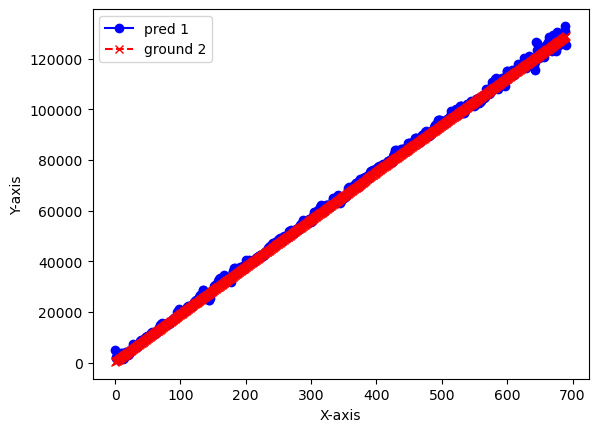

In [13]:

# Create the plot for the first list
plt.plot(pred_list, label='pred 1', linestyle='-', marker='o', color='b')

# Create the plot for the second list
plt.plot(ground_list, label='ground 2', linestyle='--', marker='x', color='r')

# Add labels and a legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()

# CREATE RENDER ENGINE

In [14]:
def create_camera_pose(translation=(0, 0, 0), rotation=(0, 0, 0)):
    """
    Create a 4x4 camera pose matrix based on translation and rotation.

    Args:
        translation (tuple): A tuple (x, y, z) for translation.
        rotation (tuple): A tuple (rx, ry, rz) for rotation in degrees.

    Returns:
        np.ndarray: A 4x4 transformation matrix representing the camera pose.
    """
    # Convert rotation angles from degrees to radians
    rx, ry, rz = np.radians(rotation)

    # Create translation matrix
    translation_matrix = np.array([
        [1, 0, 0, translation[0]],
        [0, 1, 0, translation[1]],
        [0, 0, 1, translation[2]],
        [0, 0, 0, 1]
    ])

    # Create rotation matrices for each axis
    rotation_x = np.array([
        [1, 0, 0, 0],
        [0, np.cos(rx), -np.sin(rx), 0],
        [0, np.sin(rx), np.cos(rx), 0],
        [0, 0, 0, 1]
    ])

    rotation_y = np.array([
        [np.cos(ry), 0, np.sin(ry), 0],
        [0, 1, 0, 0],
        [-np.sin(ry), 0, np.cos(ry), 0],
        [0, 0, 0, 1]
    ])

    rotation_z = np.array([
        [np.cos(rz), -np.sin(rz), 0, 0],
        [np.sin(rz), np.cos(rz), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    # Combine translation and rotation matrices
    camera_pose = translation_matrix @ rotation_x @ rotation_y @ rotation_z

    return camera_pose

In [15]:
def create_drill_pose(translation, rotation):
    # Convert degrees to radians for rotation
    rotation = [radians(angle) for angle in rotation]
    
    # Create rotation matrix using Euler angles (assuming XYZ order)
    # Note: You may need to adjust the order or method based on your needs
    rotation_matrix = np.eye(4)
    rotation_matrix[:3, :3] = (
        np.dot(
            np.dot(
                np.array([
                    [np.cos(rotation[2]), -np.sin(rotation[2]), 0],
                    [np.sin(rotation[2]), np.cos(rotation[2]), 0],
                    [0, 0, 1]
                ]),
                np.array([
                    [np.cos(rotation[1]), 0, np.sin(rotation[1])],
                    [0, 1, 0],
                    [-np.sin(rotation[1]), 0, np.cos(rotation[1])]
                ])
            ),
            np.array([
                [1, 0, 0],
                [0, np.cos(rotation[0]), -np.sin(rotation[0])],
                [0, np.sin(rotation[0]), np.cos(rotation[0])]
            ])
        )
    )
    
    # Create the translation matrix
    translation_matrix = np.eye(4)
    translation_matrix[:3, 3] = translation
    
    # Combine translation and rotation to form the pose matrix
    pose_matrix = np.dot(translation_matrix, rotation_matrix)
    
    return pose_matrix

In [16]:
def render_color_depth(model_id,model_angle):
    
    fuze_trimesh = trimesh.load('./models/fuze.obj')
    fuze_mesh = Mesh.from_trimesh(fuze_trimesh)

    # Drill trimesh
    drill_trimesh = trimesh.load('./models/drill.obj')
    drill_mesh = Mesh.from_trimesh(drill_trimesh)


    translation = (0, 0,0)
    rotation = (0, 0, model_angle)  # Rotation in degrees
    drill_pose = create_drill_pose(translation, rotation)

    # Water bottle trimesh
    bottle_gltf = trimesh.load('./models/WaterBottle.glb')
    bottle_trimesh = bottle_gltf.geometry[list(bottle_gltf.geometry.keys())[0]]
    bottle_mesh = Mesh.from_trimesh(bottle_trimesh)
    bottle_pose = np.array([
        [1.0, 0.0,  0.0, 0.0],
        [0.0, 0.0, -1.0, 0.0],
        [0.0, 1.0,  0.0, 0.0],
        [0.0, 0.0,  0.0, 1.0],
    ])

    #==============================================================================
    # Light creation
    #==============================================================================

    direc_l = DirectionalLight(color=np.ones(3), intensity=1.0)
    spot_l = SpotLight(color=np.ones(3), intensity=10.0,
                       innerConeAngle=np.pi/16, outerConeAngle=np.pi/6)
    point_l = PointLight(color=np.ones(3), intensity=10.0)

    #==============================================================================
    # Camera creation
    #==============================================================================

    cam = PerspectiveCamera(yfov=(np.pi / 3.0))
    cam_pose = np.array([
        [0.0,  -np.sqrt(2)/2, np.sqrt(2)/2, 0.4],
        [1.0, 0.0,           0.0,           0.0],
        [0.0,  np.sqrt(2)/2,  np.sqrt(2)/2, 0.4],
        [0.0,  0.0,           0.0,          1.0]
    ])

    #==============================================================================
    # Scene creation
    #==============================================================================

    scene = Scene(ambient_light=np.array([0.02, 0.02, 0.02, 1.0]))

    #==============================================================================
    # Adding objects to the scene
    #==============================================================================

    #------------------------------------------------------------------------------
    # By manually creating nodes
    #------------------------------------------------------------------------------
    fuze_node = Node(mesh=fuze_mesh, translation=np.array([0.1, 0.15, -np.min(fuze_trimesh.vertices[:,2])]))
    #scene.add_node(fuze_node)

    #------------------------------------------------------------------------------
    # By using the add() utility function
    #------------------------------------------------------------------------------
    drill_node = scene.add(drill_mesh, pose=drill_pose)
    bottle_node = scene.add(bottle_mesh, pose=bottle_pose)

    direc_l_node = scene.add(direc_l, pose=cam_pose)
    spot_l_node = scene.add(spot_l, pose=cam_pose)



    #==============================================================================
    # Rendering offscreen from that camera
    #==============================================================================

    mesh = pyrender.Mesh.from_trimesh(fuze_trimesh)
    scene = pyrender.Scene()
    #scene.add(fuze_mesh) #change this line
    scene.add(drill_mesh,pose=drill_pose) 
    camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0, aspectRatio=1.0)
    s = np.sqrt(2)/2

    translation = (0.4, 0, 0.4)
    rotation = (0, 45, 90)  # Rotation in degrees
    camera_pose = create_camera_pose(translation, rotation)

    scene.add(camera, pose=camera_pose)
    light = pyrender.SpotLight(color=np.ones(3), intensity=50.0,
                               innerConeAngle=np.pi/6.0,
                               outerConeAngle=np.pi/6.0)
    scene.add(light, pose=camera_pose)
    r = pyrender.OffscreenRenderer(256, 256)
    color, depth = r.render(scene)
    return color,depth

In [17]:

def overlay_AR_Obj(bg_image,pose_angle):
    
   

    color,depth = render_color_depth(1,pose_angle)
    
    plt.figure()
    plt.imshow(color)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(depth)
    plt.axis('off')
    plt.show()
    
    background_np = np.copy(bg_image)
    background_np_uint8 = PIL.Image.fromarray((background_np*255).astype(np.uint8))
    background = background_np_uint8.convert("RGBA")

    rendered_image = PIL.Image.fromarray((color).astype(np.uint8))

    depth = (depth > 0).astype(int)

    rendered_depth = PIL.Image.fromarray((depth*255).astype(np.uint8))
    
    plt.figure()
    plt.imshow(rendered_depth)
    plt.axis('off')
    plt.show()
    print(np.max(np.array(rendered_depth)))
    rendered_image.putalpha(rendered_depth)

    print("Background size:", background.size)
    print("Rendered image size:", rendered_image.size)

    new_img = PIL.Image.alpha_composite(background, rendered_image)
    new_img_np = np.array(new_img)
    new_img_np = new_img_np[:, :, :3]
    
    return new_img


# EXTRACT CAMERA FRAMES

In [18]:
# Convert the frame to grayscale
def get_cropped_window_for_cnn(first_frame):
    
    gray = cv2.cvtColor(first_frame, cv2.COLOR_RGB2GRAY)

    # Apply edge detection (you can use other methods like Canny edge detection)
    edges = cv2.Canny(gray, 200, 450, apertureSize=5)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True) for contour in contours
                          if len(cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)) == 4 and
                          cv2.contourArea(contour) > 100]

    best_contour = max(filtered_contours, key=cv2.contourArea, default=None)

    M = cv2.moments(best_contour)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX, cY = 0, 0


    #print(best_contour)
    # Draw the filtered contours on the original image
    result = first_frame.copy()
    cv2.drawContours(result, [best_contour], -1, (0, 255, 0), 2)


    cv2.circle(result, (cX, cY), 5, (255, 0, 0), -1)
    
    plt.figure()
    plt.imshow(result)
    plt.axis('off')
    plt.show()
    
    # Calculate the coordinates for the top-left corner of the cropping window
    top_left_x = max(cX - 128, 0)  # 128 is half of 256 (half the window size)
    top_left_y = max(cY - 128, 0)

    # Crop the window of size 256x256
    cropped_window = first_frame[top_left_y:top_left_y + 256, top_left_x:top_left_x + 256]
    
    cropped_window = cropped_window[:, :, ::-1]
    overlaid_img = overlay_AR_Obj(cropped_window,pose_f)
    overlaid_img_np = np.array(overlaid_img)
    overlaid_img_rgb = overlaid_img_np[:, :, :3]
    #overlaid_img_rgb = overlaid_img_rgb[:, :, ::-1]

    plt.imshow(overlaid_img_rgb)
    plt.axis('off')
    plt.show()

    img[top_left_y:top_left_y + 256, top_left_x:top_left_x + 256] = overlaid_img_rgb
    plt.imshow(img)
    plt.axis('off')
    plt.show()




    return cropped_window

'''
    plt.figure()
    plt.imshow(first_frame)
    plt.axis('off')
    plt.show()

    plt.figure()
    plt.imshow(cropped_window)
    plt.axis('off')
    plt.show()
'''

"\n    plt.figure()\n    plt.imshow(first_frame)\n    plt.axis('off')\n    plt.show()\n\n    plt.figure()\n    plt.imshow(cropped_window)\n    plt.axis('off')\n    plt.show()\n"

In [19]:
data_dir = "dataset_256x256_qrcode_A_yaw_pose"

images_list = []

for fname in os.listdir(data_dir):
    if fname != 'poses.txt':
        img = imageio.imread(os.path.join(data_dir, fname))
        img_arr = np.array(img)
        images_list.append(img_arr[:,:,:3]/255.0)
    else:
        angles_list, poses_list = extract_poses(os.path.join(data_dir, fname))


images_array = np.array(images_list)
angles_array = np.array(angles_list)
poses_array = np.array(poses_list)


print(f"Images Array Shape = {images_array.shape}")
print(f"Angles Array Shape = {angles_array.shape}")
print(f"Poses Array Shape = {poses_array.shape}")

Images Array Shape = (691, 256, 256, 3)
Angles Array Shape = (691,)
Poses Array Shape = (691, 6)


1/1 [==============================] - 0s 40ms/step
(256, 256, 1)
[[108.94423]]
108.94423


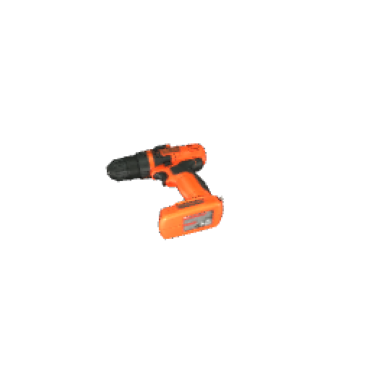

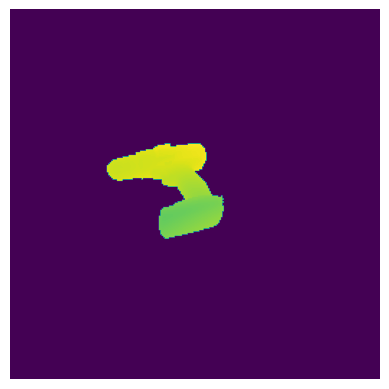

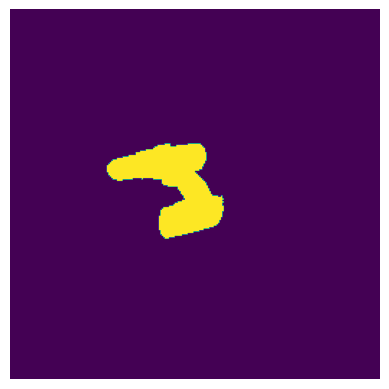

255
Background size: (256, 256)
Rendered image size: (256, 256)
SHAPE: (256, 256, 3)
counter: 0
1/1 [==============================] - 0s 39ms/step
(256, 256, 1)
[[87.05595]]
87.05595


<Figure size 640x480 with 0 Axes>

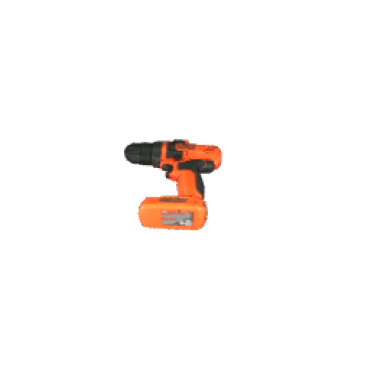

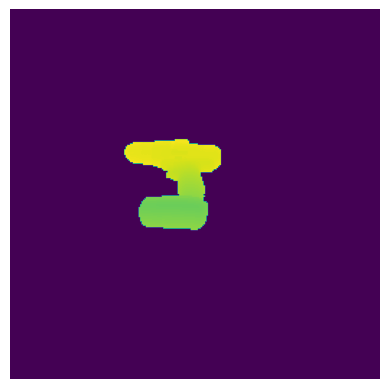

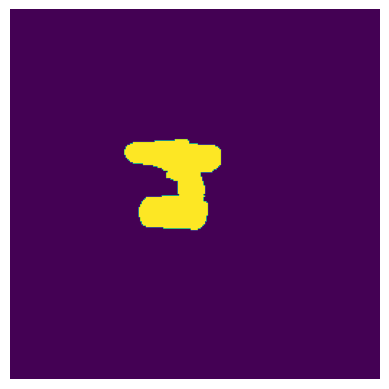

255
Background size: (256, 256)
Rendered image size: (256, 256)
SHAPE: (256, 256, 3)
counter: 1
1/1 [==============================] - 0s 34ms/step
(256, 256, 1)
[[50.72197]]
50.72197


<Figure size 640x480 with 0 Axes>

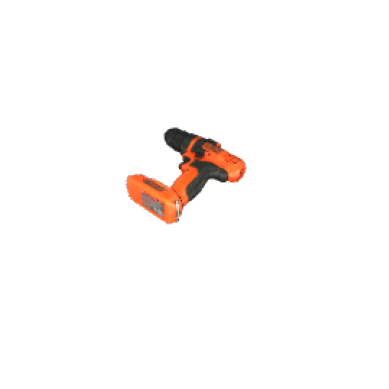

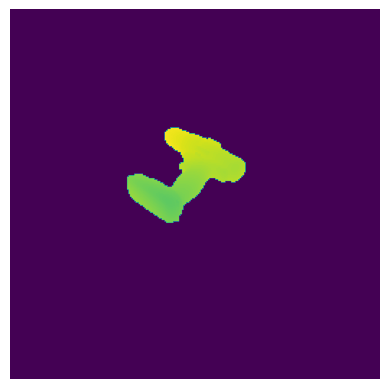

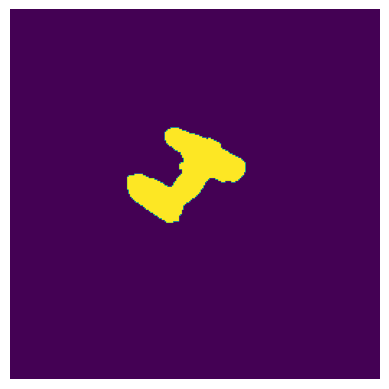

255
Background size: (256, 256)
Rendered image size: (256, 256)
SHAPE: (256, 256, 3)
counter: 2
1/1 [==============================] - 0s 38ms/step
(256, 256, 1)
[[14.581485]]
14.581485


<Figure size 640x480 with 0 Axes>

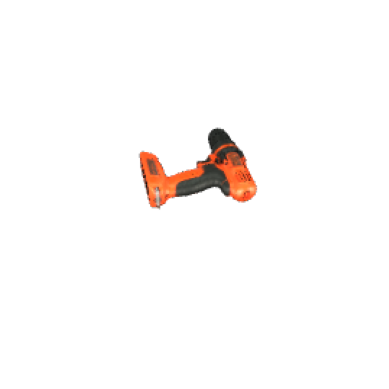

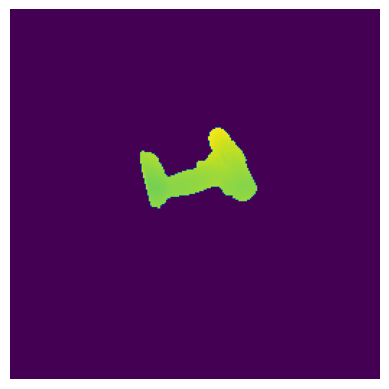

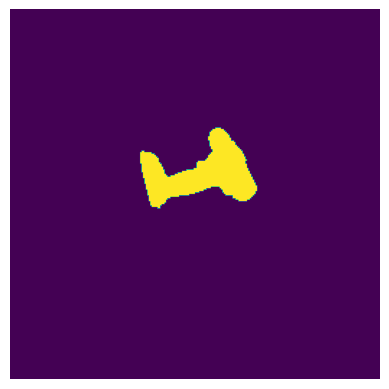

255
Background size: (256, 256)
Rendered image size: (256, 256)
SHAPE: (256, 256, 3)
counter: 3
1/1 [==============================] - 0s 35ms/step
(256, 256, 1)
[[10.71326]]
10.71326


<Figure size 640x480 with 0 Axes>

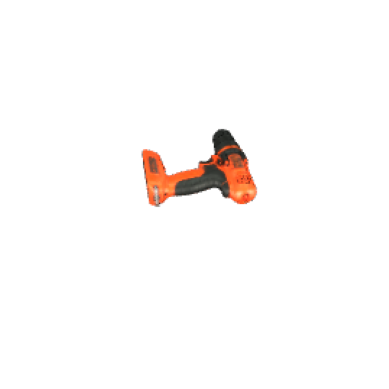

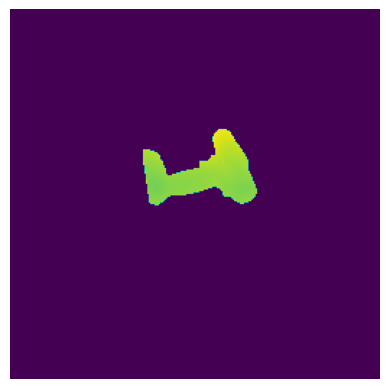

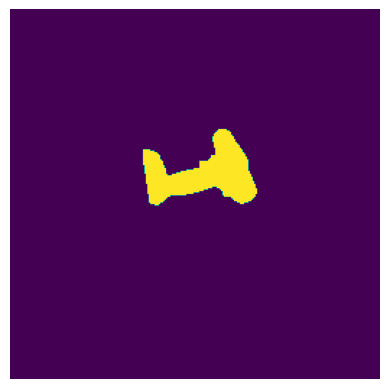

255
Background size: (256, 256)
Rendered image size: (256, 256)
SHAPE: (256, 256, 3)
counter: 4
1/1 [==============================] - 0s 46ms/step
(256, 256, 1)
[[16.418552]]
16.418552


<Figure size 640x480 with 0 Axes>

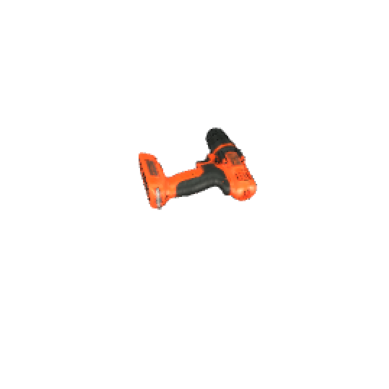

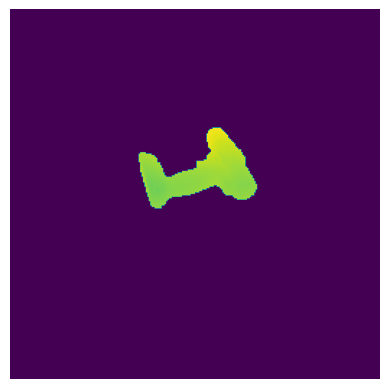

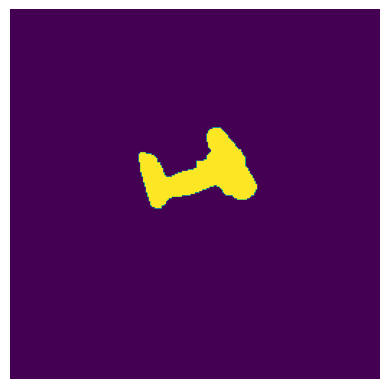

255
Background size: (256, 256)
Rendered image size: (256, 256)
SHAPE: (256, 256, 3)
counter: 5
1/1 [==============================] - 0s 38ms/step
(256, 256, 1)
[[16.213417]]
16.213417


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [19]:
out = cv2.VideoWriter('SaveVideo_Input.avi', cv2.VideoWriter_fourcc(*'DIVX'), 30.0, (256, 256))

g_counter = 0
for img in images_array:
    if g_counter == 60:
        break

    
    grayscale_image = np.mean(img, axis=2).reshape((256, 256, 1))
    predicted_pose = CNN_model.predict(grayscale_image.reshape(1,256,256,1))
    print(grayscale_image.shape)
    print(predicted_pose)
    
    pose_f = predicted_pose[0, 0]
    print(pose_f)
    overlaid_img = overlay_AR_Obj(img,pose_f)
    overlaid_img_np = np.array(overlaid_img)
    overlaid_img_rgb = overlaid_img_np[:, :, :3]
    overlaid_img_rgb = overlaid_img_rgb[:, :, ::-1]
    print("SHAPE:",overlaid_img_rgb.shape)
    

    print("counter:",g_counter)
    
    # Pause for a short duration (e.g., 0.5 seconds)
    #plt.pause(0.5)

    # Clear the current figure for the next image
    plt.clf()
    g_counter = g_counter+1
    
out.release()

# CROPPING MODULE

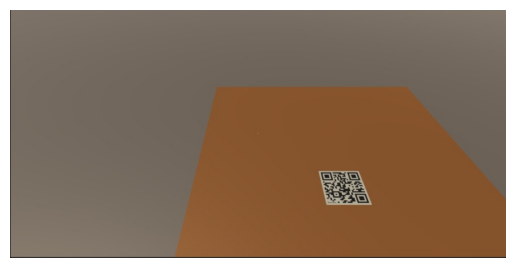

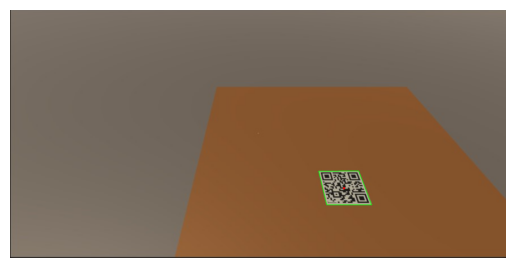

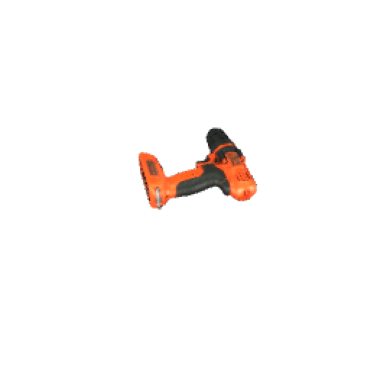

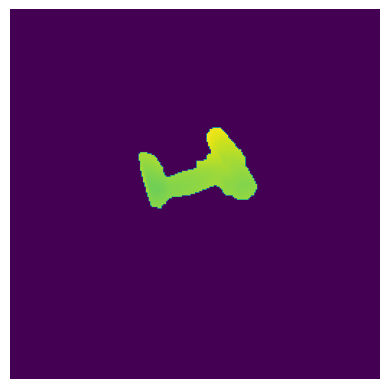

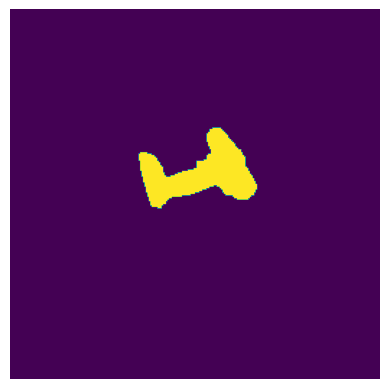

255
Background size: (256, 256)
Rendered image size: (256, 256)


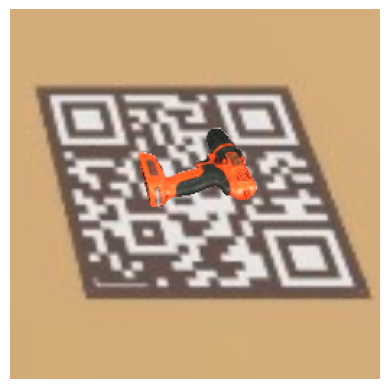

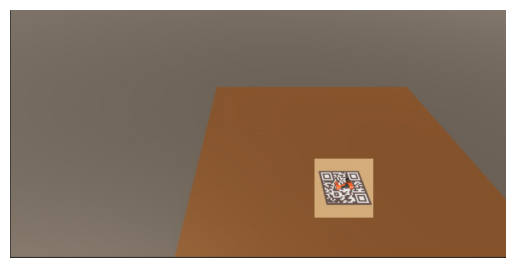

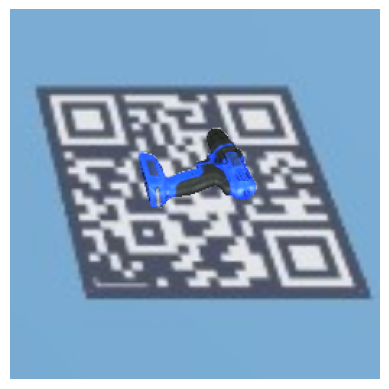

In [20]:
image_path = 'offset_camera_frame.jpEg'

# Read the image
img = cv2.imread(image_path)
img = img[:, :, ::-1]

img = cv2.resize(img, (2160,1080))
plt.imshow(img)
plt.axis('off')
plt.show()

cropped_window = get_cropped_window_for_cnn(img)
plt.imshow(cropped_window)
plt.axis('off')
plt.show()